# 
# Tracks' Genre Classification - [ *Team Emer* ]
# 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 
# Feature Selection

In [2]:
#################    ALL     #######################
# genre_names = ['Acoustic', 'R&B', 'Classical', 'Country', 'Electronic', 'Hiphop', 'Jazz', 'Pop', 'Rock', 'Reggae', "Rap"]
# feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']


#############     TYRONE    ####################
genre_names = ['Rock', 'R&B', 'Acoustic']
feature_cols =  ['danceability', 'energy', 'acousticness', 'valence', 'tempo']  #'loudness','speechiness', 'instrumentalness', 'liveness'


# ###############    RODS    #######################
# genre_names = ['Classical', 'Reggae', 'Acoustic', 'Hiphop', 'Rock']
# feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo'] #'liveness'


# ##############     G-AR    #######################
# genre_names = ['Rock', 'Hiphop', 'R&B', 'Folk', 'Indie', 'Acoustic']
# feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']


##############     KAYE    ####################
# genre_names = ['Rock', 'R&B', 'Acoustic', 'Country']
# feature_cols = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']




In [3]:
tracks = []
for i, KEYWORD in enumerate(genre_names):
    # Read and process the playlist data for keyword
    playlist_df = pd.read_csv('data/'+KEYWORD+'_playlist_data.csv')    
    tdf = pd.read_csv('data/'+KEYWORD+'_playlist_tracks_data.csv')\
    .merge(pd.read_csv('data/'+KEYWORD+'_playlist_tracks.csv')[['track_id','playlist_id','playlist_name']],\
                      on='track_id',how='left')
    
    # Make duration ms to minutes
    tdf['duration_mins'] = tdf['duration'] / 60000
    # Tag the 'genre' column with keyword then append to tmp 'tracks' dataframe
    tdf['genre'] = KEYWORD
    tdf['genre_id'] = i + 1
    tracks.append(tdf)
    
# Get union of all playlist tracks list
tracks_df = pd.concat(tracks)
# Clean the final dataframe for modeling
tracks_df = tracks_df.dropna(axis=1)
tracks_df['playlist_id'] = tracks_df['playlist_id_x']
tracks_df['playlist_name'] = tracks_df['playlist_name_x']
tracks_df = tracks_df.drop(['playlist_id_x', 'playlist_name_x', 'playlist_id_y', 'playlist_name_y'], axis=1)
tracks_df.isnull().any()

track_id            False
track_name          False
artist_id           False
artist_name         False
album_id            False
duration            False
release_date        False
popularity          False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_mins       False
genre               False
genre_id            False
playlist_id         False
playlist_name       False
dtype: bool

# 
# Dataset *(Training and Test Sets)*

In [4]:
from sklearn.model_selection import train_test_split

# Create feature matrix (X)
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

# Create the training set, test set  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ... and checking shapes
print("Shape of X_Train: " + str(X_train.shape))
print("Shape of y_Train: " + str(y_train.shape))
print("Shape of X_Test: " + str(X_test.shape))
print("Shape of y_Test: " + str(y_test.shape))

Shape of X_Train: (4193, 5)
Shape of y_Train: (4193,)
Shape of X_Test: (1049, 5)
Shape of y_Test: (1049,)


# 
# Feature Scaling

In [5]:
# Normalize numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tracks_df[feature_cols].describe()

,danceability,energy,acousticness,valence,tempo
count,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000
mean,0.573955,0.522810,0.407114,0.470666,119.257808
std,0.142378,0.252122,0.354349,0.228695,29.579259
min,0.104000,0.004720,0.000002,0.032900,53.845000
25%,0.475000,0.317000,0.053400,0.288000,95.420750
50%,0.576000,0.525000,0.315000,0.446000,117.144000
75%,0.673000,0.723000,0.778750,0.642000,139.128250
max,0.967000,0.998000,0.995000,0.985000,214.527000


### Classification and Accuracy Result Function

In [6]:
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

classifiers = []

def classify(classifier, name, X_train, y_train, y_test, y_pred, cv=10):
    # evaluate accuracy
    acc = accuracy_score(y_test, y_pred) * 100
    print(f'\nThe accuracy of the {name} classifier is {acc} %')

    # show classification report
    print('\n\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=genre_names))
    
    # show cross-validation accuracy
    accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=cv)
    print(f'\nCross-Validation Accuracy at cv={cv} is: {accuracies.mean() * 100} %\n')
    
    classifiers.append((classifier, name, accuracies.mean() * 100))
    # classifiers.append((classifier, name, acc))  ## use THIS(instead of above) to skip cross-validation accuracy metric to speed up this function call
    
    
    
    
    ###################################################################
    #######   Add code here to save the model in pickl format   #######
    ###################################################################


# 
# kNN Classifier

In [7]:
from sklearn.neighbors import KNeighborsClassifier 

# kNN model tuning
cv_scores = []
neighbors = np.arange(2,51)

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f'Fitting for k={k} \t with score={scores.mean()}')

# Changing to misclassification error
mse = [1 - x for x in cv_scores]

# Determine the best 'k'
optimal_k = neighbors[mse.index(min(mse))]
print(f'\nThe optimal number of neighbors for kNN classifier is k={optimal_k}.')

Fitting for k=2 	 with score=0.6832838958972611
Fitting for k=3 	 with score=0.7207296283668599
Fitting for k=4 	 with score=0.7119098761222865
Fitting for k=5 	 with score=0.7202545743834526
Fitting for k=6 	 with score=0.7245448346403001
Fitting for k=7 	 with score=0.7316996249573814
Fitting for k=8 	 with score=0.7281259234003864
Fitting for k=9 	 with score=0.7297965677917946
Fitting for k=10 	 with score=0.7324156154108421
Fitting for k=11 	 with score=0.7324184566428003
Fitting for k=12 	 with score=0.7336083645868849
Fitting for k=13 	 with score=0.7343209455619958
Fitting for k=14 	 with score=0.7393306057506535
Fitting for k=15 	 with score=0.7414785771110354
Fitting for k=16 	 with score=0.7436225707466757
Fitting for k=17 	 with score=0.7433844755085804
Fitting for k=18 	 with score=0.7474389135128993
Fitting for k=19 	 with score=0.7419559040800091
Fitting for k=20 	 with score=0.7455301738833958
Fitting for k=21 	 with score=0.74290828503239
Fitting for k=22 	 with score=

## Optimal kNN Model

In [8]:
# Train the model
classifier = knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
classifier.fit(X_train, y_train)

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='kNN', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the kNN classifier is 77.8836987607245 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.78      0.80      0.79       430
         R&B       0.67      0.58      0.62       220
    Acoustic       0.83      0.86      0.85       399

    accuracy                           0.78      1049
   macro avg       0.76      0.75      0.75      1049
weighted avg       0.77      0.78      0.78      1049


Cross-Validation Accuracy at cv=10 is: 74.95897261052392 %



# 
# Support Vector Machine Classifiers

In [9]:
from sklearn.svm import SVC

## SVM (Linear Kernel) Classifier

In [10]:
# Train the model
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='SVM (Linear Kernel)', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the SVM (Linear Kernel) classifier is 75.30981887511916 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.74      0.79      0.77       430
         R&B       0.60      0.50      0.55       220
    Acoustic       0.83      0.85      0.84       399

    accuracy                           0.75      1049
   macro avg       0.73      0.72      0.72      1049
weighted avg       0.75      0.75      0.75      1049


Cross-Validation Accuracy at cv=10 is: 74.48215706330265 %



## SVM (Polynomial Kernel) Classifier

In [11]:
# Train the model
classifier = SVC(kernel='poly', degree=3, gamma=0.9, probability=True)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='SVM (Polynomial Kernel)', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the SVM (Polynomial Kernel) classifier is 75.21448999046711 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.73      0.81      0.77       430
         R&B       0.65      0.49      0.56       220
    Acoustic       0.82      0.83      0.83       399

    accuracy                           0.75      1049
   macro avg       0.73      0.71      0.72      1049
weighted avg       0.75      0.75      0.75      1049


Cross-Validation Accuracy at cv=10 is: 74.43436754176611 %



## SVM (RBF Kernel) Classifier

In [12]:
# Train the model
classifier = SVC(kernel='rbf', gamma=0.8, probability=True)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='SVM (RBF Kernel)', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the SVM (RBF Kernel) classifier is 76.64442326024785 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.78      0.78      0.78       430
         R&B       0.61      0.56      0.59       220
    Acoustic       0.83      0.87      0.85       399

    accuracy                           0.77      1049
   macro avg       0.74      0.74      0.74      1049
weighted avg       0.76      0.77      0.76      1049


Cross-Validation Accuracy at cv=10 is: 75.72207068985112 %



# 
# Naive Bayes Classifier

In [13]:
from sklearn.naive_bayes import GaussianNB

# Train the model
classifier = GaussianNB()
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='Naive Bayes', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the Naive Bayes classifier is 73.02192564346997 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.75      0.75      0.75       430
         R&B       0.52      0.49      0.50       220
    Acoustic       0.82      0.84      0.83       399

    accuracy                           0.73      1049
   macro avg       0.69      0.69      0.69      1049
weighted avg       0.73      0.73      0.73      1049


Cross-Validation Accuracy at cv=10 is: 72.47920218206613 %



# 
# Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier as DT

# Train the model
classifier = DT(criterion = 'entropy', random_state=42)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='Decision Tree', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the Decision Tree classifier is 71.49666348903719 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.73      0.70      0.72       430
         R&B       0.56      0.61      0.59       220
    Acoustic       0.79      0.79      0.79       399

    accuracy                           0.71      1049
   macro avg       0.69      0.70      0.70      1049
weighted avg       0.72      0.71      0.72      1049


Cross-Validation Accuracy at cv=10 is: 69.99772701443347 %



# 
# Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier as RF

# Train the model
classifier = RF(n_estimators=10, criterion='entropy', random_state=42)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='Random Forest', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the Random Forest classifier is 76.26310772163966 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.76      0.77      0.76       430
         R&B       0.64      0.62      0.63       220
    Acoustic       0.83      0.84      0.84       399

    accuracy                           0.76      1049
   macro avg       0.74      0.74      0.74      1049
weighted avg       0.76      0.76      0.76      1049


Cross-Validation Accuracy at cv=10 is: 74.93527673599273 %



# 
# XGBoost Classifier

In [16]:
from xgboost import XGBClassifier

# Train the model
classifier = XGBClassifier(verbosity=0)
classifier.fit(X_train, y_train) 

# Test the prediction
y_pred = classifier.predict(X_test)

# Show the classification and accuracy result
classify(classifier=classifier, name='XGBoost', X_train=X_train, y_train=y_train, y_test=y_test, y_pred=y_pred)


The accuracy of the XGBoost classifier is 76.64442326024785 %


Classification Report

              precision    recall  f1-score   support

        Rock       0.78      0.76      0.77       430
         R&B       0.66      0.67      0.66       220
    Acoustic       0.82      0.83      0.82       399

    accuracy                           0.77      1049
   macro avg       0.75      0.75      0.75      1049
weighted avg       0.77      0.77      0.77      1049


Cross-Validation Accuracy at cv=10 is: 75.74610751221729 %



# 
# Best Model Selection

Which between KNN and SVM performed better? 
Create a column matching the predicted genre and probability of the better model to each of the tracks

In [17]:
classifiers

[(KNeighborsClassifier(n_neighbors=43), 'kNN', 74.95897261052392),
 (SVC(kernel='linear', probability=True),
  'SVM (Linear Kernel)',
  74.48215706330265),
 (SVC(gamma=0.9, kernel='poly', probability=True),
  'SVM (Polynomial Kernel)',
  74.43436754176611),
 (SVC(gamma=0.8, probability=True), 'SVM (RBF Kernel)', 75.72207068985112),
 (GaussianNB(), 'Naive Bayes', 72.47920218206613),
 (DecisionTreeClassifier(criterion='entropy', random_state=42),
  'Decision Tree',
  69.99772701443347),
 (RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42),
  'Random Forest',
  74.93527673599273),
 (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estim

In [18]:
from operator import itemgetter

best_model = max(classifiers, key=itemgetter(2))[0]
best_name = max(classifiers, key=itemgetter(2))[1]
best_score = max(classifiers, key=itemgetter(2))[2]
print(f"\nBest Model is '{best_name}' with accuracy score of {best_score}\n")


Best Model is 'XGBoost' with accuracy score of 75.74610751221729



### Prediction DataFrame Function

In [19]:
def create_prediction_df(df, model):
    df['predicted_genre_id'] =\
    df.apply(lambda x:  model.predict(scaler.transform(x[feature_cols].values.reshape(1,-1)))[0], axis=1)
    df['predicted_genre_prob'] =\
    df.apply(lambda x:  np.max(model.predict_proba(scaler.transform(x[feature_cols].values.reshape(1,-1)))), axis=1)
    return df

# 
# Classify *Spotify Daily Charts'* Tracks

In [20]:
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df = create_prediction_df(chart_tracks_df, best_model)
chart_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre_prob
0,0ofbQMrRDsUaVKq2mGLEAb,Havana,4nDoRrQiYLoBzwC5BhVJzF,Camila Cabello,5chBPOVY2I0bG5V3igb5QL,216896,2017-08-03,5,0.768,0.517,...,-4.323,0,0.0312,0.18600,0.000038,0.1040,0.418,104.992,2,0.895146
1,0tgVpDi06FyKpA1z0VMD4v,Perfect,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,263400,2017-03-03,86,0.599,0.448,...,-6.312,1,0.0232,0.16300,0.000000,0.1060,0.168,95.050,1,0.587232
2,3hBBKuWJfxlIlnd9QFoC8k,What Lovers Do (feat. SZA),04gDigrS5kc9YWfZHwBETP,Maroon 5,1Jmq5HEJeA9kNi2SgQul4U,199849,2017-11-03,5,0.795,0.615,...,-5.211,0,0.0671,0.07860,0.000003,0.0855,0.393,110.009,2,0.767717
3,1mXVgsBdtIVeCLJnSnmtdV,Too Good At Goodbyes,2wY79sveU1sp5g7SokKOiI,Sam Smith,3TJz2UBNYJtlEly0sPeNrQ,201000,2017-11-03,81,0.681,0.372,...,-8.237,1,0.0432,0.64000,0.000000,0.1690,0.476,91.873,1,0.621630
4,2ekn2ttSfGqwhhate0LSR0,New Rules,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,01sfgrNbnnPUEyz6GZYlt9,209320,2017-06-02,81,0.762,0.700,...,-6.021,0,0.0694,0.00261,0.000016,0.1530,0.608,116.073,2,0.531727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,0zzVTGyRrWpQu8Fr28NRAv,OK Not To Be OK,64KEffDW9EtZ1y2vBYgq8T,Marshmello,3wCtCJ8O6SlGBWYfzAlsb2,159862,2020-09-10,83,0.743,0.837,...,-5.025,0,0.0649,0.01720,0.000000,0.0743,0.263,103.072,2,0.879781
2288,4G7uzhxgKFBCJApBpuuBgU,Kabet,3ID2V4b0oGSEbwPENAsdbG,Gagong Rapper,0bFldkQiVA9IiOch2GHQGq,318040,2020-09-07,54,0.721,0.742,...,-4.967,1,0.0377,0.67000,0.000001,0.1210,0.308,79.992,2,0.967930
2289,3KUGAgxo3b81X5bWoOp0U8,Back Door,2dIgFjalVxs4ThymZ67YCE,Stray Kids,0Kp2UZGWRQHa3B5e8t93rI,189286,2020-09-14,52,0.820,0.842,...,-3.853,1,0.2720,0.15700,0.000000,0.1120,0.653,107.952,2,0.965087
2290,0rbKrBvZUYY9GN9l057BuY,"always, i'll care",3gIRvgZssIb9aiirIg0nI3,Jeremy Zucker,5mkf4N44kdEwYgaOk3hRLF,146160,2020-04-17,66,0.732,0.221,...,-12.623,1,0.0560,0.89700,0.000026,0.1100,0.677,105.165,3,0.996792


In [21]:
# Check Spotify Daily Charts' Tracks classified but with low (< 50%) probability 
chart_tracks_df[chart_tracks_df['predicted_genre_prob'] < .5]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre_prob
23,2xmrfQpmS2iJExTlklLoAL,I Miss You (feat. Julia Michaels),6MDME20pz9RveH9rEXvrOM,Clean Bandit,78zct4Yn5hwMqrlh5uQedB,205747,2017-10-26,4,0.638,0.658,...,-6.318,1,0.0456,0.2450,0.000004,0.0919,0.330,105.076,1,0.433524
39,6jA8HL9i4QGzsj6fjoxp8Y,There for You,60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,0OK35duHpTPnvqya2d4pnn,221904,2017-05-26,72,0.611,0.644,...,-7.607,0,0.0553,0.1240,0.000000,0.1240,0.130,105.969,1,0.495961
47,6NFKf8vBApSvtzkapYmnVR,Tadhana,3wbCeEPAW6po7J46netxMT,Up Dharma Down,4SjshYHT8OeSHB6zun2Hxx,222446,2012-12-07,66,0.686,0.322,...,-13.200,1,0.0369,0.1650,0.029600,0.0809,0.511,155.982,3,0.478797
49,6VpQdig9pdpTSIFItgkJV5,Never Be the Same,4nDoRrQiYLoBzwC5BhVJzF,Camila Cabello,3HR8mnPQ7Go27WPMTNR2um,227087,2017-12-17,64,0.643,0.709,...,-4.343,1,0.0733,0.1450,0.000449,0.1150,0.264,129.961,1,0.486207
62,0YyM8aEdbjGfLWPn6fdcn7,Pasensya Ka Na,4nGp682WMiKS4X217kPw8C,Silent Sanctuary,38jqi8VvSax4miNL2cacD1,241029,2015-04-08,63,0.696,0.262,...,-15.073,1,0.0310,0.5190,0.000000,0.0669,0.265,84.007,3,0.482302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,7cLrrJ1Dk6WAQyDIj9j26A,Cry About It Later,6jJ0s89eD6GaHleKKya26X,Katy Perry,47zMF6LrXQ8odi6Xv1unC0,189772,2020-08-28,71,0.699,0.669,...,-5.829,0,0.0712,0.0794,0.000017,0.2480,0.444,125.994,1,0.476753
2258,5rZlwNFl01HqLWBQGryKSm,Mood Swings (feat. Lil Tjay),0eDvMgVFoNV3TpwtrVCoTj,Pop Smoke,7e7t0MCrNDcJZsPwUKjmOc,213333,2020-07-03,93,0.480,0.602,...,-6.335,0,0.3680,0.4870,0.000000,0.0848,0.269,179.798,2,0.460010
2273,0ri0Han4IRJhzvERHOZTMr,At My Worst,1W7FNibLa0O0b572tB2w7t,Pink Sweat$,3Qj2vsFzmaB8jcH6Q60WIG,170344,2020-07-17,73,0.813,0.415,...,-5.926,1,0.0349,0.7770,0.000000,0.1310,0.667,91.921,3,0.425420
2276,1RsD951uUUlJx0MRioZfev,Cry About It Later,6jJ0s89eD6GaHleKKya26X,Katy Perry,38hfmutL8qSnflpigbMoLw,189772,2020-08-28,75,0.692,0.670,...,-5.829,0,0.0871,0.0796,0.000017,0.2480,0.445,126.004,2,0.477502


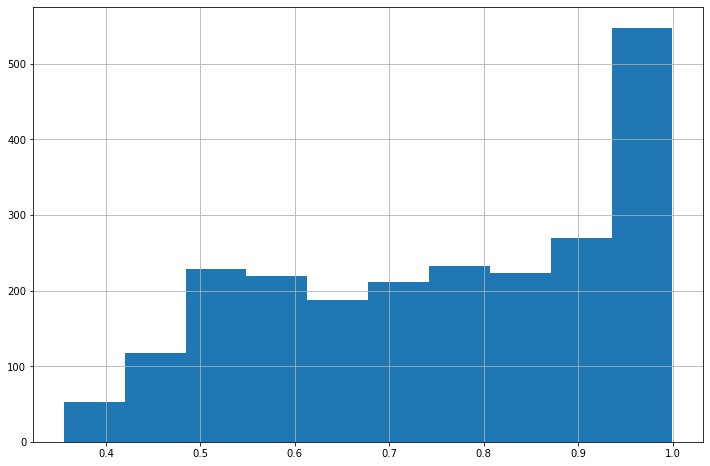

In [22]:
# View Spotify Daily Charts Tracks' histogram of probabilities
plt.figure(figsize=(12, 8))
chart_tracks_df['predicted_genre_prob'].hist()
plt.show();

# 
# Classify *Nyoy Volante's* Tracks

In [23]:
artist_name = 'Nyoy Volante'
artist_tracks_df = pd.read_csv('data/'+artist_name.lower()+'_album_tracks_data.csv')
artist_tracks_df = artist_tracks_df[artist_tracks_df['artist_name']==artist_name]\
.drop_duplicates(subset=['track_name']).reset_index()
artist_tracks_df = create_prediction_df(artist_tracks_df, best_model)
artist_tracks_df

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,predicted_genre_id,predicted_genre_prob
0,0,2pAFgfaNVioQGhC0jhtcsG,Ipagpatawad Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,239333,2012-01-01,29,0.622,...,0.0323,0.672,0.000184,0.1020,0.375,139.938,2pAFgfaNVioQGhC0jhtcsG,2pAFgfaNVioQGhC0jhtcsG,2,0.481072
1,1,33pHgWjuAXvmE6Z9b51avt,Bakit Ba Ganyan,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,312293,2012-01-01,25,0.579,...,0.0298,0.860,0.009110,0.1290,0.245,140.024,33pHgWjuAXvmE6Z9b51avt,33pHgWjuAXvmE6Z9b51avt,3,0.944890
2,2,3O7vNSKiSa5uWpaxjC4712,Pikit,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,391080,2012-01-01,11,0.651,...,0.0307,0.825,0.018100,0.1100,0.151,140.090,3O7vNSKiSa5uWpaxjC4712,3O7vNSKiSa5uWpaxjC4712,3,0.942219
3,3,2PTQBDNpLnjix9Dsa33d8l,Tuloy Pa Rin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,236453,2012-01-01,42,0.800,...,0.0359,0.721,0.007410,0.0928,0.724,110.100,2PTQBDNpLnjix9Dsa33d8l,2PTQBDNpLnjix9Dsa33d8l,1,0.837696
4,4,23kb0nomnO71oLqw7Okj3T,Magkasuyo Buong Gabi,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,235226,2012-01-01,21,0.524,...,0.0530,0.847,0.001450,0.1380,0.533,108.331,23kb0nomnO71oLqw7Okj3T,23kb0nomnO71oLqw7Okj3T,3,0.896147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,178,72OYzOOhWOakn1o9dAEcgE,"Maligayang Pasko, Mahal Kita",3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4C4T82rf97bWUn9lYjW2Vh,264040,2015-11-13,0,0.695,...,0.0332,0.360,0.000882,0.1280,0.490,150.067,72OYzOOhWOakn1o9dAEcgE,72OYzOOhWOakn1o9dAEcgE,2,0.476265
80,258,1dlWeMu46MOMYWpbT7y8RA,Kahit Maputi Na Ang Buhok Ko,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,45cXjqi3VW5dVg8cvB9gJa,197786,2013-01-01,40,0.445,...,0.0395,0.881,0.002870,0.1050,0.336,209.049,1dlWeMu46MOMYWpbT7y8RA,1dlWeMu46MOMYWpbT7y8RA,3,0.859378
81,295,5LhwNuhYJxqcCFJWLJmHsl,Slowdancing,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,68P7A2Is3ExQ8zdEfO6484,241386,2012-07-10,10,0.455,...,0.0304,0.615,0.000000,0.0924,0.320,144.059,5LhwNuhYJxqcCFJWLJmHsl,5LhwNuhYJxqcCFJWLJmHsl,3,0.829527
82,418,0EKTJuRsXuYoCeXwLUSeYz,Power of Two,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,7GNb9klVYDVzxoZWBc34Kz,305586,2011-01-01,18,0.706,...,0.0328,0.746,0.000000,0.1020,0.504,114.980,0EKTJuRsXuYoCeXwLUSeYz,0EKTJuRsXuYoCeXwLUSeYz,1,0.608957


In [24]:
# Check Artist Tracks' classified genres with but low (< 50%) probability 
artist_tracks_df[artist_tracks_df['predicted_genre_prob'] < .5]

,index,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,predicted_genre_id,predicted_genre_prob
0,0,2pAFgfaNVioQGhC0jhtcsG,Ipagpatawad Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,239333,2012-01-01,29,0.622,...,0.0323,0.672,0.000184,0.1020,0.375,139.938,2pAFgfaNVioQGhC0jhtcsG,2pAFgfaNVioQGhC0jhtcsG,2,0.481072
8,8,7czG9HV8a9oTjzoXqfos8Q,Sana Dalawa Ang Puso Ko,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,287546,2012-01-01,19,0.687,...,0.0264,0.673,0.000175,0.5320,0.229,130.196,7czG9HV8a9oTjzoXqfos8Q,7czG9HV8a9oTjzoXqfos8Q,2,0.486106
18,18,5Keg4HiBjG3LZBtwkxUOed,Sa Isip Ko - Instrumental,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4oif6qMFEOF3E6uf0bvDOV,215213,2012-01-01,1,0.615,...,0.0339,0.282,0.854000,0.1790,0.450,171.937,5Keg4HiBjG3LZBtwkxUOed,5Keg4HiBjG3LZBtwkxUOed,3,0.493298
24,24,079YDRVV6NaioJUkWD1YWG,Try,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,224240,2010-01-01,2,0.483,...,0.0329,0.626,0.000024,0.1110,0.308,139.733,079YDRVV6NaioJUkWD1YWG,079YDRVV6NaioJUkWD1YWG,1,0.441221
27,27,4M6YrTyOE1PWLIx1bqVcaA,In You,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4aW4RCeWwmde6JSVjDUgaD,292800,2010-01-01,7,0.586,...,0.0442,0.743,0.012300,0.1110,0.515,87.603,4M6YrTyOE1PWLIx1bqVcaA,4M6YrTyOE1PWLIx1bqVcaA,2,0.472585
35,35,3nI4ej3PIobYrjeTvufKDE,Nandito Lang (Hanggang Kailan),3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,1maIgsJ7htTqCDrhe8aucE,241560,2008-08-09,8,0.653,...,0.0295,0.614,0.029500,0.1990,0.473,123.207,3nI4ej3PIobYrjeTvufKDE,3nI4ej3PIobYrjeTvufKDE,3,0.490131
53,53,6bwkFs7t6ExPs5a2ER2L3i,Make You Happy,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2A48roBpFpFjatWtksmsQE,248013,2008-05-06,11,0.604,...,0.0303,0.805,0.011900,0.1250,0.337,74.138,6bwkFs7t6ExPs5a2ER2L3i,6bwkFs7t6ExPs5a2ER2L3i,3,0.474234
59,59,4hTnrPQ0EsUed8vXq4tkan,In Love Ako Sa 'Yo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,220866,2002-06-01,10,0.629,...,0.0230,0.514,0.000000,0.1010,0.458,104.963,4hTnrPQ0EsUed8vXq4tkan,4hTnrPQ0EsUed8vXq4tkan,1,0.404590
64,64,4KJVryttL1duMPn0gqWVM7,Tunay Na Tunay,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,294906,2002-06-01,6,0.560,...,0.0289,0.318,0.000000,0.0539,0.451,79.999,4KJVryttL1duMPn0gqWVM7,4KJVryttL1duMPn0gqWVM7,1,0.485925
66,66,1LsiUfQrvGHewEnzyipf6j,Love At First Sight,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,218720,2002-06-01,1,0.597,...,0.0244,0.584,0.000000,0.0990,0.639,95.071,1LsiUfQrvGHewEnzyipf6j,1LsiUfQrvGHewEnzyipf6j,2,0.475529


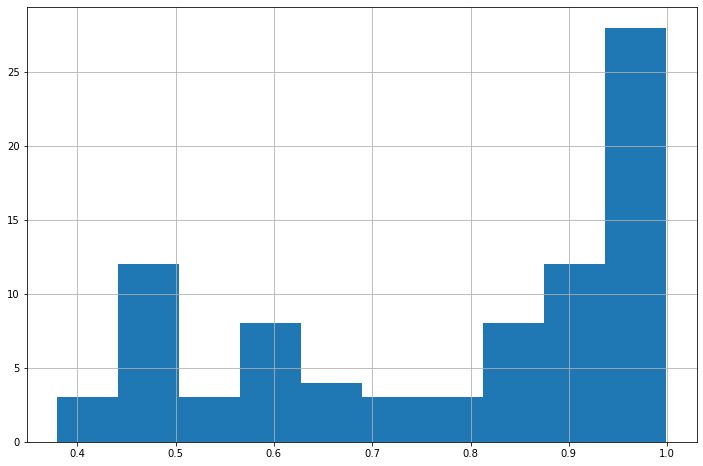

In [25]:
# View Artist Tracks' histogram of probabilities
plt.figure(figsize=(12, 8))
artist_tracks_df['predicted_genre_prob'].hist()
plt.show();

In [26]:
genre_lookup = dict(zip(np.arange(1, len(genre_names) + 1), genre_names))

artist_tracks_df = artist_tracks_df.sort_values(by=['predicted_genre_prob', 'popularity', 'release_date'], ascending=False)
artist_tracks_df['predicted_genre'] =  artist_tracks_df['predicted_genre_id'].map(lambda x: genre_lookup[x])
artist_tracks_df['classification_probability'] =  artist_tracks_df['predicted_genre_prob'].apply(lambda x: f'{x * 100.00}%')

print(f'\nArtist: {artist_name}')
cols = ['track_name', 'release_date', 'popularity', 'predicted_genre', 'classification_probability']
artist_tracks_df = artist_tracks_df[cols].reset_index()
artist_tracks_df


Artist: Nyoy Volante


,index,track_name,release_date,popularity,predicted_genre,classification_probability
0,5,Nandito Ako,2012-01-01,23,Acoustic,99.89221096038818%
1,23,Bukas Na Lang Kita Mamahalin - Instrumental,2012-01-01,13,Acoustic,99.84011054039001%
2,50,I Will,2008-05-06,26,Acoustic,99.62379932403564%
3,49,First of May,2008-05-06,15,Acoustic,99.62347149848938%
4,37,You Left Me,2008-08-09,2,Acoustic,99.59726929664612%
...,...,...,...,...,...,...
79,27,In You,2010-01-01,7,R&B,47.25848436355591%
80,77,Sintunado,2016-06-10,11,Rock,44.891706109046936%
81,24,Try,2010-01-01,2,Rock,44.12212669849396%
82,59,In Love Ako Sa 'Yo,2002-06-01,10,Rock,40.459033846855164%
